In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
import implicit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import ndcg
import MAP
from functools import reduce

from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
df = pd.read_csv('uchile-loans-18.txt', sep=';')
df.head()

,user,item,title,date
0,1068882100003936,35601000194955,111 funciones en Clipper : versión 5.01 /,2017-08-21T03:00:00Z
1,1068882100003936,35601151720236,Dendrometría /,2017-08-03T04:00:00Z
2,1068882820003936,35601006107647,Economia desde el corazon : recopilacion de lo...,2017-08-07T04:00:00Z
3,1068882820003936,35601006107647,Economia desde el corazon : recopilacion de lo...,2017-08-18T03:00:00Z
4,1068882820003936,35601154427417,Matemáticas aplicadas a la administración y ...,2017-08-30T03:00:00Z


In [17]:
# quitamos nulls 
df = df.loc[pd.isnull(df.user) == False]
df.head(5)

,user,item,title,date
0,1068882100003936,35601000194955,111 funciones en Clipper : versión 5.01 /,2017-08-21T03:00:00Z
1,1068882100003936,35601151720236,Dendrometría /,2017-08-03T04:00:00Z
2,1068882820003936,35601006107647,Economia desde el corazon : recopilacion de lo...,2017-08-07T04:00:00Z
3,1068882820003936,35601006107647,Economia desde el corazon : recopilacion de lo...,2017-08-18T03:00:00Z
4,1068882820003936,35601154427417,Matemáticas aplicadas a la administración y ...,2017-08-30T03:00:00Z


In [18]:
num_users = len(df['user'].unique())
num_books = len(df['item'].unique())
print('usuarios: {}'.format(num_users))
print('libros: {}'.format(num_books))
print('prestamos por usuario: {}'.format(num_books/num_users))

usuarios: 7685
libros: 36610
prestamos por usuario: 4.763825634352635


In [22]:
# creamos df con items unicos para hacer busqueda por id mas eficiente 
item_lookup = df[['item', 'title']].drop_duplicates() 
item_lookup['item'] = item_lookup.item.astype(str) 

In [27]:
df['user'] = df.user.astype(str)
grouped_books = df.groupby(["user", "item"]).size().reset_index(name="Quantity")
grouped_books.head(5)

,user,item,Quantity
0,1068882100003936,35601000194955,1
1,1068882100003936,35601151720236,1
2,1068882820003936,35601006107647,2
3,1068882820003936,35601154427417,1
4,1068882820003936,35601154878395,1


### libros mas arrendados: 

In [48]:
item_df = grouped_books.groupby(['item']).sum()

#libros mas arrendados (computador personal¿? , Notebook Toshiba¿?)
books_df = item_df.sort_values(by='Quantity', ascending=False)
books_df['item'] = books_df.index
books_df = books_df[['item', 'Quantity']]
mas_arrendado_df = books_df.merge(df, on='item').drop_duplicates('title').head()
mas_arrendado_df[['title', 'Quantity']]

,title,Quantity
0,Computador personal [realia],146
542,Diccionario ilustrado latino-español español...,79
886,Microeconomía y conducta /,55
1036,Notebook Toshiba Satellite,44
1165,Diccionario ilustrado latín : latino-español...,42


In [49]:
books_data = books_df.groupby(['Quantity']).count()
books_data['Quantity'] = books_data.index
books_data = books_data[['item', 'Quantity']]
books_data.columns = ['#items', 'quantity lends']

# existen 29.772 libros que han sido arrendados una sola vez, libro mas arrendado "computador personal"
books_data.head(5)


,#items,quantity lends
Quantity,,
1,29772,1
2,3400,2
3,1359,3
4,675,4
5,390,5


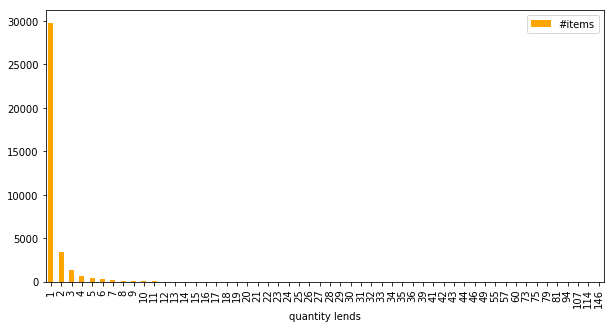

In [52]:
# 29.772 libros han sido arrendados una vez 
books_data = books_data.head(100)
books_plot = books_data.plot.bar(x='quantity lends',y='#items', color='orange', figsize=(10,5))

### usuarios que mas han arrendado: 

In [53]:
user_df = grouped_books.groupby(['user']).sum()
user_df['user'] = user_df.index
user_df = user_df[['user', 'Quantity']]
user_df.sort_values(by='Quantity', ascending=False).head(5)

,user,Quantity
user,,
1720643430003936,1720643430003936,8410
1749816590003936,1749816590003936,495
1720601200003936,1720601200003936,314
1738975340003936,1738975340003936,204
1737308380003936,1737308380003936,159


In [54]:
users_data = user_df.groupby(['Quantity']).count()
users_data['Quantity'] = users_data.index

users_data.columns = ['#users', '#arriendos']

# hay 2274 usuarios que han arrendado tan solo un libro
users_data.head(5)

,#users,#arriendos
Quantity,,
2,2274,2
3,1352,3
4,865,4
5,643,5
6,504,6


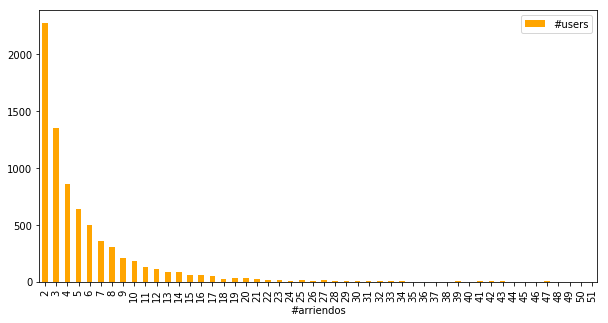

In [56]:
# hay 2274 usuarios que han arrendado una sola vez, 1352 usuarios que han arrendado 2 veces....
users_data = users_data.head(50)
users_plot = users_data.plot.bar(x='#arriendos',y='#users', color='orange', figsize=(10,5))

### Creamos matriz sparsed user - item - quantity

In [146]:
users = list(np.sort(grouped_books.user.unique())) 
books = list(grouped_books.item.unique()) 
quantity = list(grouped_books.Quantity) 
rows = grouped_books.user.astype('category', categories = users).cat.codes 
cols = grouped_books.item.astype('category', categories = books).cat.codes 
books_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(users), len(books)))
books_sparse

<7685x36610 sparse matrix of type '<class 'numpy.int64'>'
	with 51260 stored elements in Compressed Sparse Row format>

In [147]:
matrix_size = books_sparse.shape[0]*books_sparse.shape[1] 
num_book_loans = len(books_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_book_loans/matrix_size))
sparsity

99.98178056096751

In [148]:
'''recibe matriz sparsed y la divide 80/20 training y testing'''
def make_train(sparse_matrix, pct_test = 0.2):
    total_users =  7685 #users (rows de sparse matrix)
    tramo = round(total_users * (1-pct_test))
    training_set = sparse_matrix[0:tramo] 
    test_set = sparse_matrix[(tramo+1)::]
    
    return training_set, test_set  # retornamos una matriz sparse de train y de testing 

In [161]:
# split sparsed matrix
train_dataset, test_dataset = make_train(books_sparse, pct_test = 0.2)

# split dataframe 
train, test = train_test_split(grouped_books, test_size=0.2)

print(train_dataset.shape)
print(test_dataset.shape)


(6148, 36610)
(1536, 36610)


In [165]:
def get_books(user):
    return df.loc[df['user'] == user]

def get_books_test(user):
    return test.loc[test['user'] == user][['item']]
    

In [168]:
users_list = list(df['user'].unique())
items_list = list(df['item'].unique())

users_arr = np.array(users_list)
items_arr = np.array(items_list)

# libros arrendados por usuario 100 de la lista
print('libros arrendados por user_id: {}'.format(users_list[100]))
get_books(users_list[100])

libros arrendados por user_id: 1720476660003936


,user,item,title,date
552,1720476660003936,35601007473121,Cálculo y geometría analítica /,2012-05-23T04:00:00Z
553,1720476660003936,35601010882045,Mecánica vectorial para ingenieros /,2012-05-23T04:00:00Z


In [169]:
def rec_items(user_id, mf_train, user_vecs, item_vecs, user_list, item_list, item_lookup, num_items = 10):    
    cust_ind = np.where(user_list == user_id)[0][0] # obtener el index de users id
    pref_vec = mf_train[cust_ind,:].toarray() 
    pref_vec = pref_vec.reshape(-1) + 1 # asignamos 1 a todo, asi las historias no favoriteadas tendrán valor 1. 
    pref_vec[pref_vec > 1] = 0 # reemplazamos todo lo que ya fue favorito en zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # producto punto users e items transpuesto
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    # todos los items ya recomendados se multiplican por cero 
    recommend_vector = pref_vec*rec_vector_scaled 
    stories_idx = np.argsort(recommend_vector)[::-1][:num_items] # ordenamos los items y 
    # arriba quedan las mejores recomendaciones 
    rec_list = [] 
    for index in stories_idx:
        code = item_list[index]
        rec_list.append(code) 
    return rec_list # devolvemos una lista con los top 5 (num_items)

In [180]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((train_dataset*alpha).astype('double'), 
                                                          factors=100, 
                                                          regularization = 0.1, 
                                                         iterations = 100)

This method is deprecated. Please use the AlternatingLeastSquares class instead


In [181]:
# recomendacion implicita para el primer usuario de la lista
recommendation = rec_items(users_list[100], train_dataset, user_vecs, item_vecs, users_arr, items_arr, item_lookup,
                       num_items = 5)

In [182]:
# recomendacion para el usuario 100 de la lista ¿alargador electrico?
df_recommended = pd.DataFrame({'item': recommendation})
df_recommended.merge(df, on='item').drop_duplicates(subset='item')[['item', 'title']]

,item,title
0,35601200029290,Derecho familiar chileno /
14,35601201656984,[Alargador múltiple múltiple blanco marca Bt...
27,35601200092223,Código civi : especial para estudiantes /
41,35601201657008,[Alargador eléctrico múltiple blanco marca T...
51,35601200092371,Código de comercio : especial para estudiantes /


In [183]:
users_list = list(df['user'].unique())
items_list = list(df['item'].unique())

users_arr = np.array(users_list)
items_arr = np.array(items_list)

# libros arrendados por usuario 100 de la lista
print('libros arrendados por user_id: {}'.format(users_list[100]))
get_books(users_list[100])

libros arrendados por user_id: 1720476660003936


,user,item,title,date
552,1720476660003936,35601007473121,Cálculo y geometría analítica /,2012-05-23T04:00:00Z
553,1720476660003936,35601010882045,Mecánica vectorial para ingenieros /,2012-05-23T04:00:00Z


### Recomendacion implicit feedback: 

In [ ]:
data = []

alpha = 15 

#alpha - parametro discutido en el paper de Koren & Volinsky asociado a la matriz de confianza, 
#donde Cui = 1 + alpha*Rui. 
# Rui --> preferencia del usuario "u" por el item "i" , si Rui > 0 hay una preferencia (interaccion)
#En el paper obtienen que el default de alpha debe ser 40 (el mas efectivo) . 


user_vecs, item_vecs = implicit.alternating_least_squares((train_dataset*alpha).astype('double'), 
                                                                  factors=300, 
                                                                  regularization = 0.1, 
                                                                 iterations = 100)

# OJO al hacer el corte de train y test algunos usuarios no estan en ambos, por eso recomendamos a 10000 usuarios 
for x in users_arr[0:1500]:

    user_id = x
    
    print(user_id)
    
    # recomienda con dataset de test
    recommendation_test = rec_items(user_id, test_dataset, user_vecs, item_vecs, users_arr, items_arr, item_lookup,
                           num_items = 5)
    
    fav_stories = list(get_books_test(x)['item'])

    relevantes = []
    for x in recommendation_test:
        if x in fav_stories:
            relevantes.append(1)
        else:
            relevantes.append(0)

    ndcg5 = ndcg.ndcg(relevantes,5)
    precision5 = MAP.precision_at_k(relevantes,5)
    lista_MAP = [MAP.precision_at_k(relevantes,x) for x in range(1, len(relevantes))]
    mean_average_precision = reduce(lambda x, y: x + y, lista_MAP) / len(lista_MAP)

    #print(ndcg10)
    #print(precision10)
    #print(mean_average_precision)

    data.append(['{}'.format(user_id), ndcg5, precision5, mean_average_precision])

    df_result = pd.DataFrame(data, columns = ('user', 'ndcg@5', 'precision@5', 'MAP'))

#df_result
df_result.to_csv('implicit_results_UCHILE.csv', sep=';', index=False)

In [198]:
result = pd.read_csv('implicit_results_UCHILE.csv', sep=';')
result.describe()[['ndcg@5', 'precision@5', 'MAP']]

,ndcg@5,precision@5,MAP
count,1500.000000,1500.000000,1500.000000
mean,0.301303,0.106533,0.142972
std,0.383352,0.141789,0.223357
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.630930,0.200000,0.270833
max,1.000000,0.800000,0.937500
